<a href="https://colab.research.google.com/github/ChandrashekharRobbi/LipNet/blob/main/LipNet_From_Start_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install and Import Dependencies

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.5.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.2
astunparse                       1.6.3
async-timeout                    4.0.3
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0


In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

In [7]:
!pip install --upgrade gdown


  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [8]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=True)
gdown.extractall('data.zip')

['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [10]:
!unzip "data.zip"

Archive:  data.zip
   creating: data/
   creating: data/alignments/
   creating: data/alignments/s1/
  inflating: data/alignments/s1/bbaf2n.align  
  inflating: data/alignments/s1/bbaf3s.align  
  inflating: data/alignments/s1/bbaf4p.align  
  inflating: data/alignments/s1/bbaf5a.align  
  inflating: data/alignments/s1/bbal6n.align  
  inflating: data/alignments/s1/bbal7s.align  
  inflating: data/alignments/s1/bbal8p.align  
  inflating: data/alignments/s1/bbal9a.align  
  inflating: data/alignments/s1/bbas1s.align  
  inflating: data/alignments/s1/bbas2p.align  
  inflating: data/alignments/s1/bbas3a.align  
  inflating: data/alignments/s1/bbaszn.align  
  inflating: data/alignments/s1/bbaz4n.align  
  inflating: data/alignments/s1/bbaz5s.align  
  inflating: data/alignments/s1/bbaz6p.align  
  inflating: data/alignments/s1/bbaz7a.align  
  inflating: data/alignments/s1/bbbf6n.align  
  inflating: data/alignments/s1/bbbf7s.align  
  inflating: data/alignments/s1/bbbf8p.align  
  infl

In [11]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [12]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [14]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [15]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [16]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [17]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [18]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [95]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    # print(path)
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    print("Path in Load data",path)
    # file_name = path.split('\\')[-1].split('.')[0]
    print("filename in load data", file_name)
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    # print(file_name)
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    print("Path in load data of alignment",alignment_path)
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [96]:
'data/s1/lrid9s.mpg'.split('/')[-1]

'lrid9s.mpg'

In [97]:
test_path = './data/s1/bbas2p.mpg'

In [98]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

''

In [99]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

Path in Load data ./data/s1/bbas2p.mpg
filename in load data bbas2p
Path in load data of alignment data/alignments/s1/bbas2p.align


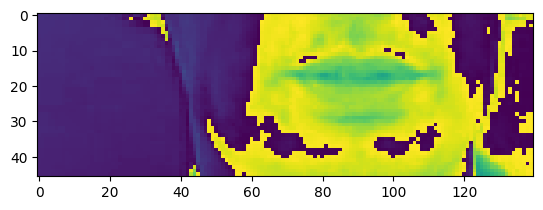

In [100]:
plt.imshow(frames[40])

In [101]:
alignments

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 19, 39, 20, 23, 15,
       39, 16, 12,  5,  1, 19,  5])>

In [102]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at s two please'>

In [103]:
def mappable_function(path:str) ->List[str]:
    print("p",path)
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [104]:
from matplotlib import pyplot as plt

In [105]:
data = tf.data.Dataset.list_files('data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

p Tensor("args_0:0", shape=(), dtype=string)


In [106]:
frames, alignments = data.as_numpy_iterator().next()

Path in Load data data/s1/prap5s.mpg
filename in load data prap5s
Path in load data of alignment data/alignments/s1/prap5s.align
Path in Load data data/s1/pwwk5s.mpg
filename in load data pwwk5s
Path in load data of alignment data/alignments/s1/pwwk5s.align


In [107]:
len(test)

50

In [108]:
frames, alignments = data.as_numpy_iterator().next()

Path in Load data data/s1/lriezp.mpg
filename in load data lriezp
Path in load data of alignment data/alignments/s1/lriezp.align
Path in Load data data/s1/lbwe7a.mpg
filename in load data lbwe7a
Path in load data of alignment data/alignments/s1/lbwe7a.align


In [109]:
len(frames)

2

In [160]:
sample = data.as_numpy_iterator()

In [161]:
val = sample.next(); val[0]

Path in Load data data/s1/pbai5s.mpg
filename in load data pbai5s
Path in load data of alignment data/alignments/s1/pbai5s.align
Path in Load data data/s1/pwip6n.mpg
filename in load data pwip6n
Path in load data of alignment data/alignments/s1/pwip6n.align
Path in Load data data/s1/lgbf8n.mpg
filename in load data lgbf8n
Path in load data of alignment data/alignments/s1/lgbf8n.align


array([[[[[ 1.4670175 ],
          [ 1.4670175 ],
          [ 1.4670175 ],
          ...,
          [ 0.04191479],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.4670175 ],
          [ 1.4670175 ],
          [ 1.4670175 ],
          ...,
          [ 0.04191479],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.4670175 ],
          [ 1.4670175 ],
          [ 1.3831879 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 1.0059549 ],
          [ 1.0059549 ],
          [ 0.9640401 ],
          ...,
          [10.436782  ],
          [10.436782  ],
          [10.436782  ]],

         [[ 1.0059549 ],
          [ 1.0059549 ],
          [ 0.9640401 ],
          ...,
          [10.436782  ],
          [10.436782  ],
          [10.436782  ]],

         [[ 1.0059549 ],
          [ 1.0059549 ],
          [ 0.9640401 ],
          ...,
          [10.436782  ],
          [10.436782  ],
          

In [162]:
val[0][0]

array([[[[ 1.4670175 ],
         [ 1.4670175 ],
         [ 1.4670175 ],
         ...,
         [ 0.04191479],
         [ 0.        ],
         [ 0.        ]],

        [[ 1.4670175 ],
         [ 1.4670175 ],
         [ 1.4670175 ],
         ...,
         [ 0.04191479],
         [ 0.        ],
         [ 0.        ]],

        [[ 1.4670175 ],
         [ 1.4670175 ],
         [ 1.3831879 ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        ...,

        [[ 1.0059549 ],
         [ 1.0059549 ],
         [ 0.9640401 ],
         ...,
         [10.436782  ],
         [10.436782  ],
         [10.436782  ]],

        [[ 1.0059549 ],
         [ 1.0059549 ],
         [ 0.9640401 ],
         ...,
         [10.436782  ],
         [10.436782  ],
         [10.436782  ]],

        [[ 1.0059549 ],
         [ 1.0059549 ],
         [ 0.9640401 ],
         ...,
         [10.436782  ],
         [10.436782  ],
         [10.436782  ]]],


       [[[ 1.3412732 ],


In [164]:
import numpy as np
image_data = (val[0][0] * 255).astype(np.uint8)
image_data = np.squeeze(image_data)
import imageio
imageio.mimsave('./animaton.gif', image_data, duration=2000)


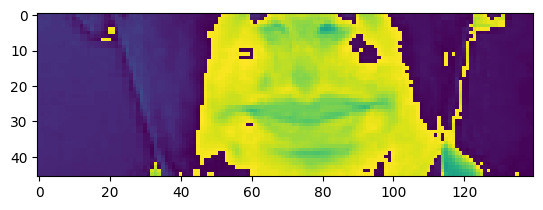

In [152]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [153]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in z one soon'>

# 3. Design the Deep Neural Network

In [165]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [166]:
data.as_numpy_iterator().next()[0][0].shape

Path in Load data data/s1/bbaf5a.mpg
filename in load data bbaf5a
Path in load data of alignment data/alignments/s1/bbaf5a.align
Path in Load data data/s1/prwq3s.mpg
filename in load data prwq3s
Path in load data of alignment data/alignments/s1/prwq3s.align
Path in Load data data/s1/lwwf9a.mpg
filename in load data lwwf9a
Path in load data of alignment data/alignments/s1/lwwf9a.align


(75, 46, 140, 1)

In [167]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [168]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [169]:
5*17*75

6375

In [170]:
yhat = model.predict(val[0])

1/1 [==============================] - 33s 33s/step


In [171]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkzzzzz'>

In [172]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkzzzzz'>

In [173]:
model.input_shape

(None, 75, 46, 140, 1)

In [174]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [175]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [176]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [177]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [191]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [192]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [193]:
schedule_callback = LearningRateScheduler(scheduler)

In [194]:
example_callback = ProduceExample(test)

In [195]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
Path in Load data data/s1/bbil4p.mpg
filename in load data bbil4p
Path in load data of alignment data/alignments/s1/bbil4p.align
Path in Load data data/s1/prap5s.mpg
filename in load data prap5s
Path in load data of alignment data/alignments/s1/prap5s.align
Path in Load data data/s1/bgia3s.mpg
filename in load data bgia3s
Path in load data of alignment data/alignments/s1/bgia3s.align
Path in Load data data/s1/swavzp.mpg
filename in load data swavzp
Path in load data of alignment data/alignments/s1/swavzp.align
Path in Load data data/s1/pbbv6n.mpg
filename in load data pbbv6n
Path in load data of alignment data/alignments/s1/pbbv6n.align
  2/450 [..............................] - ETA: 4:05 - loss: 208.9491   Path in Load data data/s1/pwaj7s.mpg
filename in load data pwaj7s
Path in load data of alignment data/alignments/s1/pwaj7s.align
Path in Load data data/s1/pgwl2p.mpg
filename in load data pgwl2p
Path in load data of alignment data/alignments/s1/pgwl2p.align
  3/450 [....

KeyboardInterrupt: ignored

# 5. Make a Prediction

In [196]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 167MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [197]:
model.load_weights('models/checkpoint')

In [198]:
test_data = test.as_numpy_iterator()

In [199]:
sample = test_data.next()

Path in Load data data/s1/srab3a.mpg
filename in load data srab3a
Path in load data of alignment data/alignments/s1/srab3a.align
Path in Load data data/s1/pwbkzn.mpg
filename in load data pwbkzn
Path in load data of alignment data/alignments/s1/pwbkzn.align
Path in Load data data/s1/priv7a.mpg
filename in load data priv7a
Path in load data of alignment data/alignments/s1/priv7a.align
Path in Load data data/s1/lbij7s.mpg
filename in load data lbij7s
Path in load data of alignment data/alignments/s1/lbij7s.align
Path in Load data data/s1/bgaa8p.mpg
filename in load data bgaa8p
Path in load data of alignment data/alignments/s1/bgaa8p.align
Path in Load data data/s1/pbbp4p.mpg
filename in load data pbbp4p
Path in load data of alignment data/alignments/s1/pbbp4p.align
Path in Load data data/s1/srbi1a.mpg
filename in load data srbi1a
Path in load data of alignment data/alignments/s1/srbi1a.align
Path in Load data data/s1/bgan5s.mpg
filename in load data bgan5s
Path in load data of alignment 

In [204]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 248ms/step


In [205]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white in p six now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red at r zero now'>]

In [206]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [207]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white in p six now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red at r zero now'>]

# Test on a Video

In [210]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

Path in Load data ./data/s1/bras9a.mpg
filename in load data bras9a
Path in load data of alignment data/alignments/s1/bras9a.align


In [211]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [212]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [213]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [214]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]